In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

Let's compare the different streaks:

In [110]:
df = pd.read_csv('laliga_optimized.csv')
df.head()

,id,season,division,round,localTeam,visitorTeam,localGoals,visitorGoals,date,result,...,local_3streak,visitor_3streak,local_5streak,visitor_5streak,last_1ra_loc,last_1ra_vis,Rk_loc,Rk_vis,last_top6_loc,last_top6_vis
0,11702,1987-88,1,1,Atletico de Bilbao,Mallorca,2,1,1987-08-29,2,...,0.0,0.0,0.0,0.0,1,1,1.0,1.0,0,0
1,11703,1987-88,1,1,Espanol,Celta de Vigo,0,1,1987-08-29,0,...,0.0,0.0,0.0,0.0,1,1,1.0,1.0,0,0
2,11704,1987-88,1,1,Sporting de Gijon,Valladolid,0,0,1987-08-29,1,...,0.0,0.0,0.0,0.0,1,1,1.0,1.0,0,0
3,11705,1987-88,1,1,Valencia,Logrones,2,0,1987-08-29,2,...,0.0,0.0,0.0,0.0,1,1,1.0,1.0,0,0
4,11706,1987-88,1,1,Atletico de Madrid,Sabadell,1,0,1987-08-30,2,...,0.0,0.0,0.0,0.0,1,1,1.0,1.0,0,0


In [111]:
df.drop(['id','division','date'], axis=1, inplace=True)
df.drop(['local_5streak', 'visitor_5streak','local_3streak','visitor_3streak','total_punts_loc','total_punts_vis'], axis=1, inplace=True)
y = df['result']
X = df.drop(['result'], axis=1)
M_goals = df[['localGoals', 'visitorGoals']]
X.drop(['localGoals', 'visitorGoals'], axis=1, inplace=True)

XlocalTeam = X['localTeam']
XvisitorTeam = X['visitorTeam']
X.drop(['localTeam','visitorTeam'], axis = 1, inplace = True)

STRATIFY:

In [115]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33, stratify=y)

In [116]:
X_train['season'] = X_train['season'].apply(lambda x: int(x[:4]))
from sklearn.preprocessing import OrdinalEncoder

ord_enc_season = OrdinalEncoder()
ord_enc_round = OrdinalEncoder()
ord_enc_month = OrdinalEncoder()
ord_enc_day_of_week = OrdinalEncoder()

X_train['season'] = ord_enc_season.fit(X_train['season'].values.reshape(-1, 1)).transform(X_train['season'].values.reshape(-1, 1))
X_train['round'] = ord_enc_round.fit(X_train['round'].values.reshape(-1, 1)).transform(X_train['round'].values.reshape(-1, 1))
X_train['month'] = ord_enc_month.fit(X_train['month'].values.reshape(-1, 1)).transform(X_train['month'].values.reshape(-1, 1))
X_train['day_of_week'] = ord_enc_day_of_week.fit(X_train['day_of_week'].values.reshape(-1, 1)).transform(X_train['day_of_week'].values.reshape(-1, 1))



#### NORMALIZE

In [117]:
keys_normalizer = X_train.keys()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit(X_train).transform(X_train)
X_train = pd.DataFrame(X_train, columns=keys_normalizer)

## MODELING:

### LOGISTIC REGRESSION:

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
log_reg = LogisticRegression()
#OvR by default
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
conf_log_reg_train = confusion_matrix(y_train, y_train_pred)
print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       0.46      0.32      0.38      2102
           1       0.40      0.01      0.02      2137
           2       0.53      0.89      0.67      4026

    accuracy                           0.52      8265
   macro avg       0.46      0.41      0.35      8265
weighted avg       0.48      0.52      0.43      8265



In [119]:
print("Basic Logistic Regression Train Accuracy: ", log_reg.score(X_train, y_train))

Basic Logistic Regression Train Accuracy:  0.5188142770719903


In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from tqdm import tqdm

models = {
    #'Logistic Regression': (LogisticRegression(), {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10]}),
    #'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [3, 4, 5, 6, 7, 9], 'min_samples_split': [2, 3, 4, 5, 6]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [100, 200, 300, 400], 'max_depth': [8, 9, 10, 11, 12], 'min_samples_split': [3, 4, 5, 6]}),
    #'SVC': (SVC(), {'kernel': ['linear', 'rbf', 'sigmoid'], 'C': [1, 10, 50, 100, 150]}), #triga massa (>45min)
    #'KNN': (KNeighborsClassifier(), {'n_neighbors': [11, 13, 15, 17, 19], 'weights': ['uniform', 'distance']}),
    #'XGBoost': (XGBClassifier(), {'n_estimators': [5, 10, 20, 50, 100], 'max_depth': [1, 2, 3, 4], 'learning_rate': [0.01, 0.05, 0.1, 0.2]}),
    #'Bagging': (BaggingClassifier(), {'n_estimators': [300, 400, 500], 'max_samples': [0.1, 0.5, 1.0], 'max_features': [0.1, 0.5, 1.0]}),
    #'OvR Logistic Regression': (LogisticRegression(multi_class='ovr'), {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10]}),
    #'OvO Logistic Regression': (LogisticRegression(multi_class='multinomial', solver='newton-cg'), {'penalty': ['l2'], 'C': [0.001, 0.01, 0.05, 0.1, 1]})
}
    
for name, (model, params) in tqdm(models.items()):
    print('Model: ', name)
    grid = GridSearchCV(model, params, cv=skf, scoring='accuracy', n_jobs=-1) #usem n_jobs per a paralelitzar el màxima possible
    grid.fit(X_train, y_train)
    print('Best score: ', grid.best_score_)
    print('Best params: ', grid.best_params_)
    print('-----------------------------------------------------')
    
    

  0%|          | 0/1 [00:00<?, ?it/s]

Model:  Random Forest


100%|██████████| 1/1 [05:33<00:00, 333.87s/it]

Best score:  0.5203871748336357
Best params:  {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 400}
-----------------------------------------------------


In [120]:
#no local_3streak i visitor_3streak
# best_models1 = {
#     'Basic Logistic Regression': LogisticRegression(),
#     'Random Forest': RandomForestClassifier(n_estimators= 400, max_depth= 9, min_samples_split= 3),
#     'XGBoost': XGBClassifier(n_estimators = 100, max_depth = 3, learning_rate = 0.1),
#     #'Bagging': (BaggingClassifier(), {'n_estimators': [], 'max_samples': [], 'max_features': []}),
#     'OvR Logistic Regression': LogisticRegression(multi_class='ovr', penalty = 'l2', C = 0.01),
#     'OvO Logistic Regression': LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty = 'l2', C = 0.1)
# }

#no local_5streak i visitor_5streak ni local_3streak i visitor_3streak
best_models2 = {
    'Basic Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators= 400, max_depth= 10, min_samples_split= 3),
    'XGBoost': XGBClassifier(n_estimators = 20, max_depth = 4, learning_rate = 0.01),
    #'Bagging': (BaggingClassifier(), {'n_estimators': [], 'max_samples': [], 'max_features': []}),
    'OvR Logistic Regression': LogisticRegression(multi_class='ovr', penalty = 'l2', C = 0.1),
    'OvO Logistic Regression': LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty = 'l2', C = 0.01)
 }
#no local_5streak i visitor_5streak 
# best_models3 = {
#     'Basic Logistic Regression': LogisticRegression(),
#     'Random Forest': RandomForestClassifier(n_estimators= 300, max_depth= 10, min_samples_split= 5),
#     'XGBoost': XGBClassifier(n_estimators = 50, max_depth = 4, learning_rate = 0.05),
#     #'Bagging': (BaggingClassifier(), {'n_estimators': [], 'max_samples': [], 'max_features': []}),
#     'OvR Logistic Regression': LogisticRegression(multi_class='ovr', penalty = 'l2', C = 0.01),
#     'OvO Logistic Regression': LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty = 'l2', C = 0.01)
# }

Prepare X_test

In [123]:
X_test_original = X_test.copy()

X_test['season'] = X_test['season'].apply(lambda x: int(x[:4]))

X_test['season'] = ord_enc_season.transform(X_test['season'].values.reshape(-1, 1))
X_test['round'] = ord_enc_round.transform(X_test['round'].values.reshape(-1, 1))
X_test['month'] = ord_enc_month.transform(X_test['month'].values.reshape(-1, 1))
X_test['day_of_week'] = ord_enc_day_of_week.transform(X_test['day_of_week'].values.reshape(-1, 1))

keys_normalizer = X_test.keys()


In [124]:
#transform:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=keys_normalizer)

In [125]:
#Train with best hyperparameters:
for name, model in best_models2.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

#Let's see the results:
models_acc = {}
for name, model in best_models2.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    models_acc[name] = report['accuracy']

models_f1 = pd.DataFrame.from_dict(models_acc, orient='index', columns=['accuracy'])
models_f1.sort_values(by='accuracy', ascending=False, inplace=True)
models_f1
    

Training Basic Logistic Regression...
Training Random Forest...
Training XGBoost...
Training OvR Logistic Regression...
Training OvO Logistic Regression...


c:\Users\genis\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\genis\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\genis\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\genis\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

,accuracy
XGBoost,0.511797
Basic Logistic Regression,0.511434
Random Forest,0.510708
OvR Logistic Regression,0.509982
OvO Logistic Regression,0.508530


In [126]:
#feature importances dictionary:
feature_importances_dic = {}
for name, model in best_models2.items():
    if name not in ['Basic Logistic Regression', 'OvO Logistic Regression', 'OvR Logistic Regression']:
        feat_imp_aux = model.feature_importances_
        feature_importances_dic[name] = feat_imp_aux

df_feature_importances = pd.DataFrame(feature_importances_dic, index = X_test.columns)

df_feature_importances
        

,Random Forest,XGBoost
season,0.089887,0.039378
round,0.062291,0.040862
T1PliS,0.089847,0.029541
T1PviS,0.096980,0.050880
T2PliS,0.090165,0.032135
T2PviS,0.083351,0.044136
month,0.032933,0.000000
day_of_week,0.028932,0.015449
GoalsliS,0.084077,0.017043
GoalsviS,0.089364,0.018294


GRAPHICS:

[0.0, 0.21323339364174299, 0.9948933637225155, 1.2792045552448617]


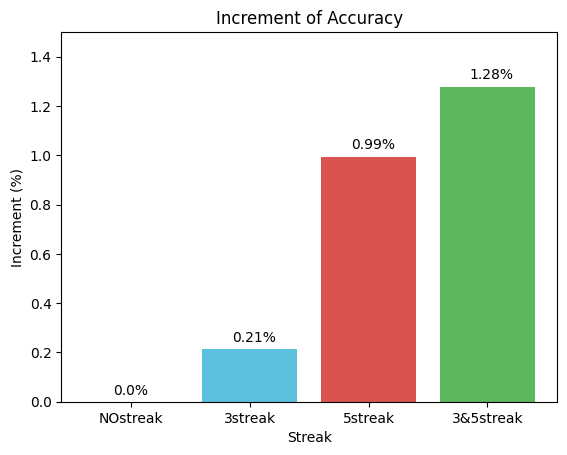

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
#NOstreak, 3streak, 5streak and 3&5streak in test
labels = ['NOstreak', '3streak', '5streak', '3&5streak']
accuracy = [0.510708, 0.511797, 0.515789, 0.517241]

# pd.DataFrame({'Accuracy': accuracy}, index=labels).plot.bar(rot=0, color=['#5cb85c', '#5bc0de', '#d9534f'])
# plt.title('Accuracy of Random Forest Model')
# plt.xlabel('Streak')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 0.52])
# plt.show()
#compute a list which relates the NOstreak with its increment
increment =  [(acc / accuracy[0] - 1) * 100 for acc in accuracy]
print(increment)

#plot the incrementation with the best plot for this case
plt.bar(labels, increment, color=['#5cb85c', '#5bc0de', '#d9534f'])
plt.title('Increment of Accuracy')
plt.xlabel('Streak')
plt.ylabel('Increment (%)')
plt.ylim([0, 1.5])
#add the value of each bar
for i, v in enumerate(increment):
    plt.text(i - 0.15, v + 0.03, str(round(v, 2)) + '%')

plt.show()

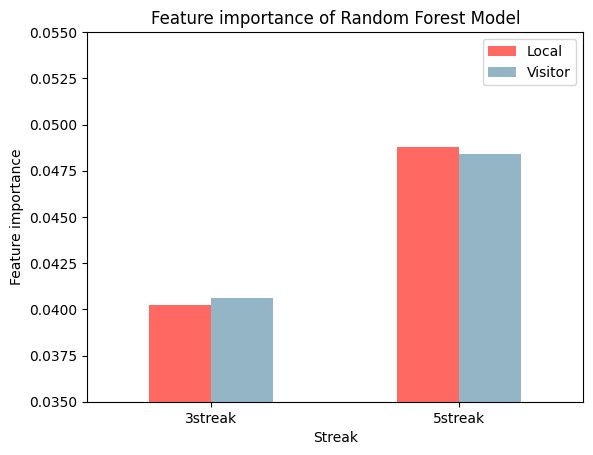

In [2]:
#Feature importance of the models
labels = ['3streak', '5streak']
#tuple: (local,visitor) feature importance in random forest pel cas 3streak i 5streak
feature_importance = [(0.040227,0.040629), (0.048801,0.048430)]

pd.DataFrame({'Local': [i[0] for i in feature_importance], 'Visitor': [i[1] for i in feature_importance]}, index=labels).plot.bar(rot=0, color=['#FF6961', '#93B5C6'])
plt.title('Feature importance of Random Forest Model')
plt.xlabel('Streak')
plt.ylabel('Feature importance')
plt.ylim([0.035, 0.055])
plt.show()